<a href="https://colab.research.google.com/github/kebabee/autoencoder-memory/blob/main/associative_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Associative memory in autoencoders

The Hopfield network (and especially the dense associative memory) provided associative memory in the neural network. Such a network learns the patterns themselves and does not learn the noise, yet is able to reproduce patterns with different types of noise or with only part of the pattern. Is this the only architecture at which it is not necessary to learn noise to correctly reproduce patterns?

## Case study

I will try to implement associative memory in autoencoder. The idea is simple:
* A simple autoencoder learns to reconstruct 1000 MNIST digits without any noise, pixel clipping, etc.
* After learning, in the autoencoder input I put digits with noise, halved, etc.
* I count the difference between noisy and original and between restored and original.

If the reconstructed digits are more similar to the originals than the noisy ones, it can be concluded that somehow the associative memory has been successfully implemented.

## First autoencoder

We have 5 layers: 784 neurons - 256 - 64 - 256 - 784. The autoencoder learns 1000 digits (100 for each one) with different number of epochs (from 1 to 201 every 10). The test set is different variations of "spoiled" digits. We have consecutively:
* 10% randomly picked pixels set to random float from 0.0 to 1.0 (original [0,255] is scaled to [0,1])
* 20% random pixels set to random float
* 30% random pixels set to random float
* 40% random pixels set to random float
* 50% random pixels set to random float

Loading MNIST and libraries:


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

selected_digits = []
for digit in range(10):
  idx = np.where(y_train == digit)[0][:100]
  selected_digits.append(x_train[idx])

selected_digits = np.array(selected_digits).reshape(-1, 28, 28)
selected_digits = selected_digits.astype('float32') / 255.0 # rescale to [0,1]
selected_digits = selected_digits.reshape(-1, 784) # to vector

preparing spoiled digits:

In [2]:
import random

def add_noise(images, noise_factor):
    noisy_images = images.copy()
    n_pixels = int(noise_factor * images.shape[1])
    for img in noisy_images:
        noise_idx = np.random.choice(images.shape[1], n_pixels, replace=False)
        for i in range(n_pixels):
            img[noise_idx[i]] = random.uniform(0.0, 1.0)
    return noisy_images

rand10_digits = add_noise(selected_digits, 0.1)
rand20_digits = add_noise(selected_digits, 0.2)
rand30_digits = add_noise(selected_digits, 0.3)
rand40_digits = add_noise(selected_digits, 0.4)
rand50_digits = add_noise(selected_digits, 0.5)

defining simple autoencoder:

In [3]:
input_img = Input(shape=(784,))
encoded = Dense(256, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### Sample:
Autoecnoder learned digits for 50 epochs, it is tested for selected test datasets.


Epoch 1/50
5/5 [==============================] - 5s 61ms/step - loss: 0.6719
Epoch 2/50
5/5 [==============================] - 0s 44ms/step - loss: 0.5193
Epoch 3/50
5/5 [==============================] - 0s 49ms/step - loss: 0.3504
Epoch 4/50
5/5 [==============================] - 0s 56ms/step - loss: 0.3023
Epoch 5/50
5/5 [==============================] - 0s 41ms/step - loss: 0.2798
Epoch 6/50
5/5 [==============================] - 0s 38ms/step - loss: 0.2707
Epoch 7/50
5/5 [==============================] - 0s 51ms/step - loss: 0.2595
Epoch 8/50
5/5 [==============================] - 0s 49ms/step - loss: 0.2519
Epoch 9/50
5/5 [==============================] - 0s 49ms/step - loss: 0.2445
Epoch 10/50
5/5 [==============================] - 0s 50ms/step - loss: 0.2366
Epoch 11/50
5/5 [==============================] - 0s 42ms/step - loss: 0.2278
Epoch 12/50
5/5 [==============================] - 0s 39ms/step - loss: 0.2184
Epoch 13/50
5/5 [==============================] - 0s 49ms/st

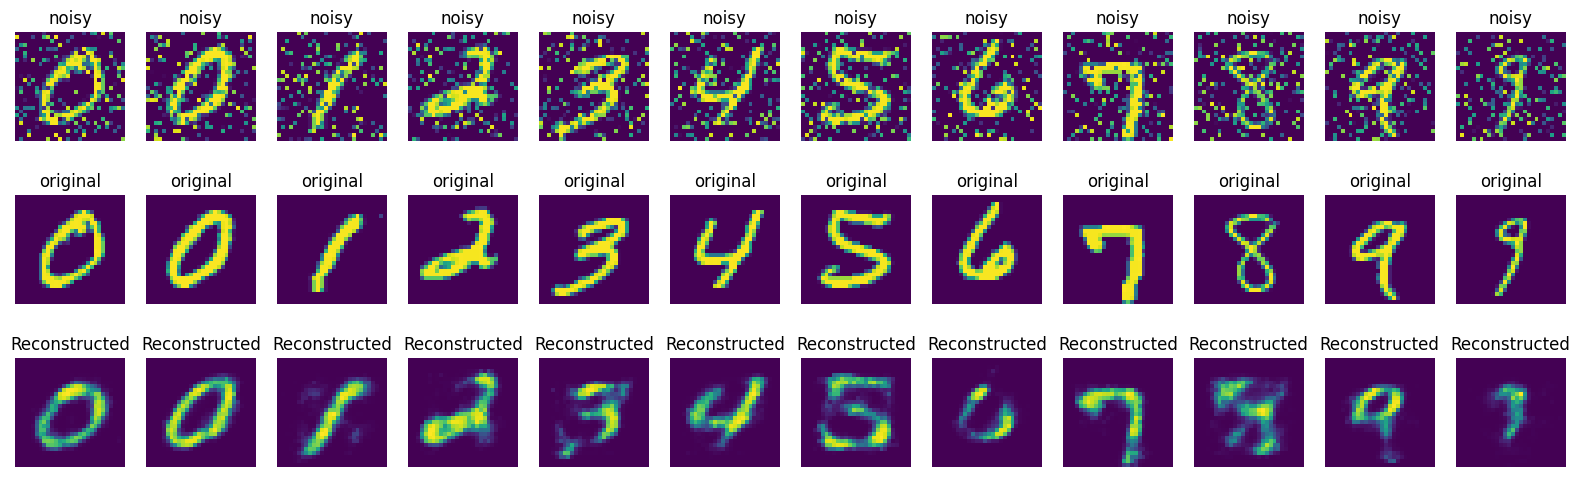

Mean difference between original and 20% noised: 0.09578946977853775
Mean difference between original and reconstructed: 0.07091712206602097


In [4]:
autoencoder.fit(selected_digits, selected_digits, epochs=50, batch_size=200, shuffle=True)
#autoencoder.save('simple_autoencoder.h5')

def plot_images(original, noisy, reconstructed, n):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy[90*i].reshape(28, 28))
        plt.title("noisy")
        plt.axis('off')

        # display noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(original[90*i].reshape(28, 28))
        plt.title("original")
        plt.axis('off')

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed[90*i].reshape(28, 28))
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

decoded_imgs = autoencoder.predict(rand20_digits)

plot_images(selected_digits, rand20_digits, decoded_imgs, n=12)

mean_diff_noisy_original = np.mean(np.abs(selected_digits - rand20_digits))
mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))

print(f"Mean difference between original and 20% noised: {mean_diff_noisy_original}")
print(f"Mean difference between original and reconstructed: {mean_diff_decoded_original}")

The digits returned by the autoencoder turned out to be slightly more similar to the originals than the input noisy digits, so some "repair" happened. I will run multiple autoencoders with different test datasets and number of epochs to investigate this relation in more details.

Just to check, how this autoencoder works with "predicting" originals?

32/32 [==============================] - 0s 4ms/step


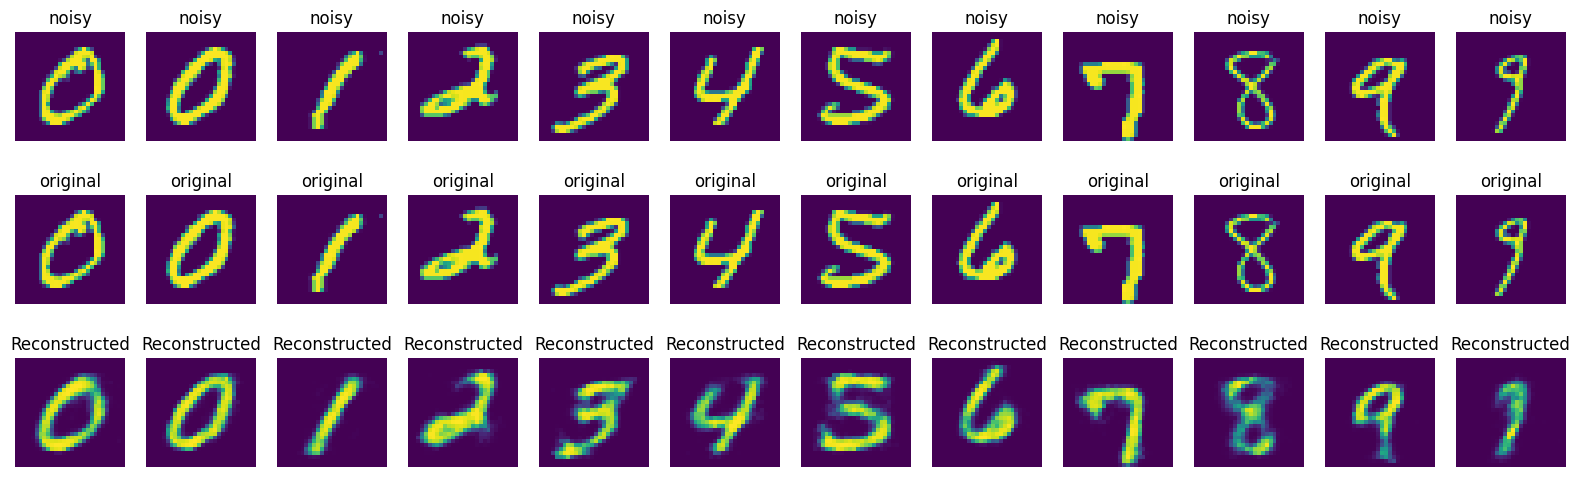

Mean difference between original and original xD: 0.0
Mean difference between original and reconstructed: 0.046280451118946075


In [5]:
decoded_imgs_3 = autoencoder.predict(selected_digits)

plot_images(selected_digits, selected_digits, decoded_imgs_3, n=12)

mean_diff_noisy_original_3 = np.mean(np.abs(selected_digits - selected_digits)) #duh
mean_diff_decoded_original_3 = np.mean(np.abs(selected_digits - decoded_imgs_3))

print(f"Mean difference between original and original xD: {mean_diff_noisy_original_3}")
print(f"Mean difference between original and reconstructed: {mean_diff_decoded_original_3}")

## Main experiment

I will record "factor of differences" as:
$$a=\frac{\text{Mean difference between original and decoded}}{\text{Mean difference between original and noised}}$$
with independent $a$ for every test dataset.

When $a<1$ it means that the reconstructed digits are more similar to the originals than the noised ones. This is situation that I am looking for. In addition I will check how the quality of "originals to originals" prediction changes with number of epochs.

In [6]:
a_rand10 = []
a_rand20 = []
a_rand30 = []
a_rand40 = []
a_rand50 = []
diff_rand10 = []
diff_rand20 = []
diff_rand30 = []
diff_rand40 = []
diff_rand50 = []
originals_diffs = []

mean_diff_rand10_original = np.mean(np.abs(selected_digits - rand10_digits))
mean_diff_rand20_original = np.mean(np.abs(selected_digits - rand20_digits))
mean_diff_rand30_original = np.mean(np.abs(selected_digits - rand30_digits))
mean_diff_rand40_original = np.mean(np.abs(selected_digits - rand40_digits))
mean_diff_rand50_original = np.mean(np.abs(selected_digits - rand50_digits))

epochs = np.linspace(0, 101, 52)
#epochs = [10,20,30]
for e in epochs:
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
  autoencoder.fit(selected_digits, selected_digits, epochs=int(e), batch_size=200, shuffle=True, verbose=0)

  decoded_imgs = autoencoder.predict(rand10_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand10.append(mean_diff_decoded_original)
  a_rand10.append(mean_diff_decoded_original/mean_diff_rand10_original)

  decoded_imgs = autoencoder.predict(rand20_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand20.append(mean_diff_decoded_original)
  a_rand20.append(mean_diff_decoded_original/mean_diff_rand20_original)

  decoded_imgs = autoencoder.predict(rand30_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand30.append(mean_diff_decoded_original)
  a_rand30.append(mean_diff_decoded_original/mean_diff_rand30_original)

  decoded_imgs = autoencoder.predict(rand40_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand40.append(mean_diff_decoded_original)
  a_rand40.append(mean_diff_decoded_original/mean_diff_rand40_original)

  decoded_imgs = autoencoder.predict(rand50_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand50.append(mean_diff_decoded_original)
  a_rand50.append(mean_diff_decoded_original/mean_diff_rand50_original)

  decoded_imgs = autoencoder.predict(selected_digits)
  originals_diffs.append(np.mean(np.abs(selected_digits - decoded_imgs)))

print(a_rand10)
print(a_rand20)
print(a_rand30)
print(a_rand40)
print(a_rand50)
print(originals_diffs)


32/32 [==============================] - 0s 3ms/step
[1.1800652, 1.2477642, 1.2003721, 1.1535246, 1.1043626, 1.0751804, 1.028794, 0.99152654, 0.9514345, 0.9316587, 0.8956143, 0.88182795, 0.86754394, 0.85683024, 0.84940517, 0.8454854, 0.8522491, 0.84884983, 0.8545166, 0.87029415, 0.87145084, 0.8819287, 0.89069, 0.90754825, 0.91448206, 0.9293332, 0.94671, 0.96044326, 0.9710018, 0.99250746, 0.9954669, 1.0109098, 1.0212437, 1.0357876, 1.0498416, 1.0590256, 1.0716372, 1.0817046, 1.0944878, 1.1078329, 1.1203281, 1.1306473, 1.1365328, 1.1491486, 1.1631794, 1.1696106, 1.1820124, 1.1954161, 1.1961145, 1.2075263, 1.2215433, 1.2273266]
[0.74034363, 0.7683717, 0.7532209, 0.7371304, 0.7167009, 0.71022385, 0.68799144, 0.6724257, 0.65326375, 0.64964503, 0.632359, 0.6297624, 0.6255226, 0.6265069, 0.62765956, 0.6308119, 0.6407995, 0.6427999, 0.6494218, 0.6617832, 0.6656257, 0.6731318, 0.67981416, 0.6907505, 0.6956018, 0.70629096, 0.71720606, 0.7264304, 0.73441035, 0.7467094, 0.7501968, 0.7598719, 0.767

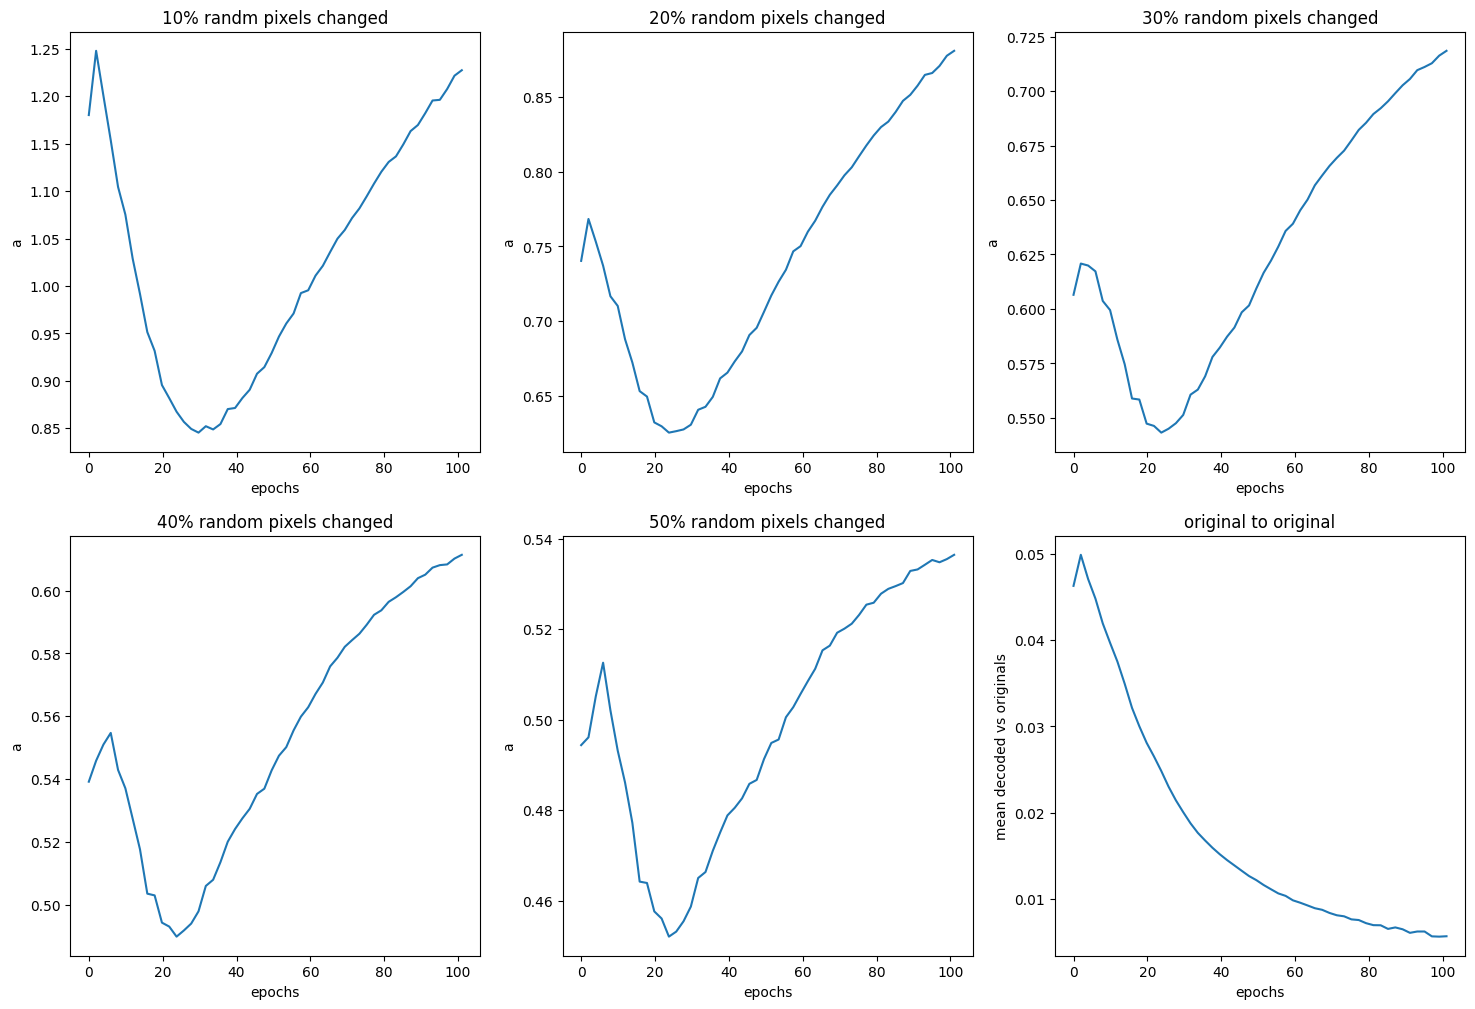

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, a_rand10)
plt.xlabel('epochs')
plt.ylabel('a')
plt.title('10% randm pixels changed')

plt.subplot(2, 3, 2)
plt.plot(epochs, a_rand20)
plt.xlabel('epochs')
plt.ylabel('a')
plt.title('20% random pixels changed')

plt.subplot(2, 3, 3)
plt.plot(epochs, a_rand30)
plt.xlabel('epochs')
plt.ylabel('a')
plt.title('30% random pixels changed')

plt.subplot(2, 3, 4)
plt.plot(epochs, a_rand40)
plt.xlabel('epochs')
plt.ylabel('a')
plt.title('40% random pixels changed')

plt.subplot(2, 3, 5)
plt.plot(epochs, a_rand50)
plt.xlabel('epochs')
plt.ylabel('a')
plt.title('50% random pixels changed')

plt.subplot(2, 3, 6)
plt.plot(epochs, originals_diffs)
plt.xlabel('epochs')
plt.ylabel('mean decoded vs originals')
plt.title('original to original')

plt.show()


It seems like somewhere in the beginning of the training ($\approx 20$-th epoch) the model is trained enought to know something about digits, but not trained enought to be overfitted. Sure, the reconstruction of original images get better over the training, but the goal of "ignoring" the noise gets worse.

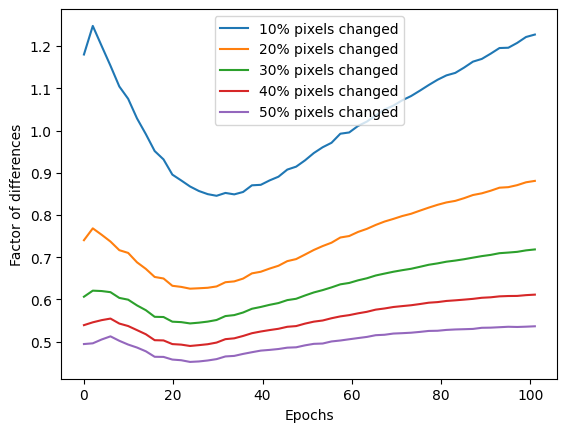

In [8]:
plt.plot(epochs, a_rand10, label='10% pixels changed')
plt.plot(epochs, a_rand20, label='20% pixels changed')
plt.plot(epochs, a_rand30, label='30% pixels changed')
plt.plot(epochs, a_rand40, label='40% pixels changed')
plt.plot(epochs, a_rand50, label='50% pixels changed')
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.legend()
plt.show()

Autoencoder seems like to repair better the more noised digits. This may be purely a result of the fact that the heavily noisy data is simply different enough from the original data that the result is not very usefull. Here the change of "pure" mean difference between decoded and original (with minimas):

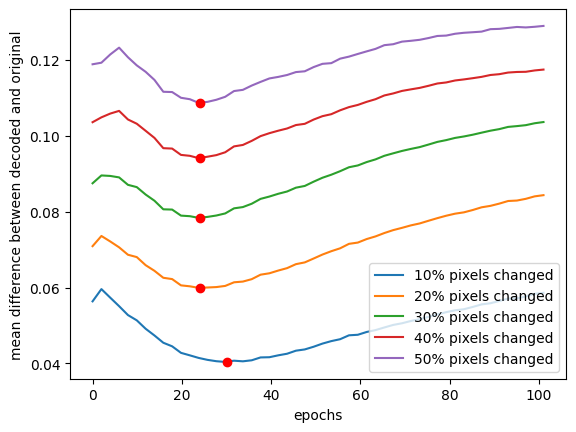

In [9]:
plt.plot(epochs, diff_rand10, label='10% pixels changed')
plt.plot(epochs, diff_rand20, label='20% pixels changed')
plt.plot(epochs, diff_rand30, label='30% pixels changed')
plt.plot(epochs, diff_rand40, label='40% pixels changed')
plt.plot(epochs, diff_rand50, label='50% pixels changed')
plt.plot(2*np.argmin(diff_rand10),np.min(diff_rand10),'ro')
plt.plot(2*np.argmin(diff_rand20),np.min(diff_rand20),'ro')
plt.plot(2*np.argmin(diff_rand30),np.min(diff_rand30),'ro')
plt.plot(2*np.argmin(diff_rand40),np.min(diff_rand40),'ro')
plt.plot(2*np.argmin(diff_rand50),np.min(diff_rand50),'ro')
plt.xlabel('epochs')
plt.ylabel('mean difference between decoded and original')
plt.legend()
plt.show()

## Same analysis, but for more complex autoencoder

In [14]:
input_img = Input(shape=(784,))
encoded = Dense(256, activation='relu')(input_img)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

a_rand10 = []
a_rand20 = []
a_rand30 = []
a_rand40 = []
a_rand50 = []
diff_rand10 = []
diff_rand20 = []
diff_rand30 = []
diff_rand40 = []
diff_rand50 = []
originals_diffs = []

mean_diff_rand10_original = np.mean(np.abs(selected_digits - rand10_digits))
mean_diff_rand20_original = np.mean(np.abs(selected_digits - rand20_digits))
mean_diff_rand30_original = np.mean(np.abs(selected_digits - rand30_digits))
mean_diff_rand40_original = np.mean(np.abs(selected_digits - rand40_digits))
mean_diff_rand50_original = np.mean(np.abs(selected_digits - rand50_digits))

epochs = np.linspace(0, 101, 52)
#epochs = [10,20,30]
for e in epochs:
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
  autoencoder.fit(selected_digits, selected_digits, epochs=int(e), batch_size=200, shuffle=True, verbose=0)

  decoded_imgs = autoencoder.predict(rand10_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand10.append(mean_diff_decoded_original)
  a_rand10.append(mean_diff_decoded_original/mean_diff_rand10_original)

  decoded_imgs = autoencoder.predict(rand20_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand20.append(mean_diff_decoded_original)
  a_rand20.append(mean_diff_decoded_original/mean_diff_rand20_original)

  decoded_imgs = autoencoder.predict(rand30_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand30.append(mean_diff_decoded_original)
  a_rand30.append(mean_diff_decoded_original/mean_diff_rand30_original)

  decoded_imgs = autoencoder.predict(rand40_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand40.append(mean_diff_decoded_original)
  a_rand40.append(mean_diff_decoded_original/mean_diff_rand40_original)

  decoded_imgs = autoencoder.predict(rand50_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand50.append(mean_diff_decoded_original)
  a_rand50.append(mean_diff_decoded_original/mean_diff_rand50_original)

  decoded_imgs = autoencoder.predict(selected_digits)
  originals_diffs.append(np.mean(np.abs(selected_digits - decoded_imgs)))

32/32 [==============================] - 0s 3ms/step


#### Predicting originals test

32/32 [==============================] - 0s 3ms/step


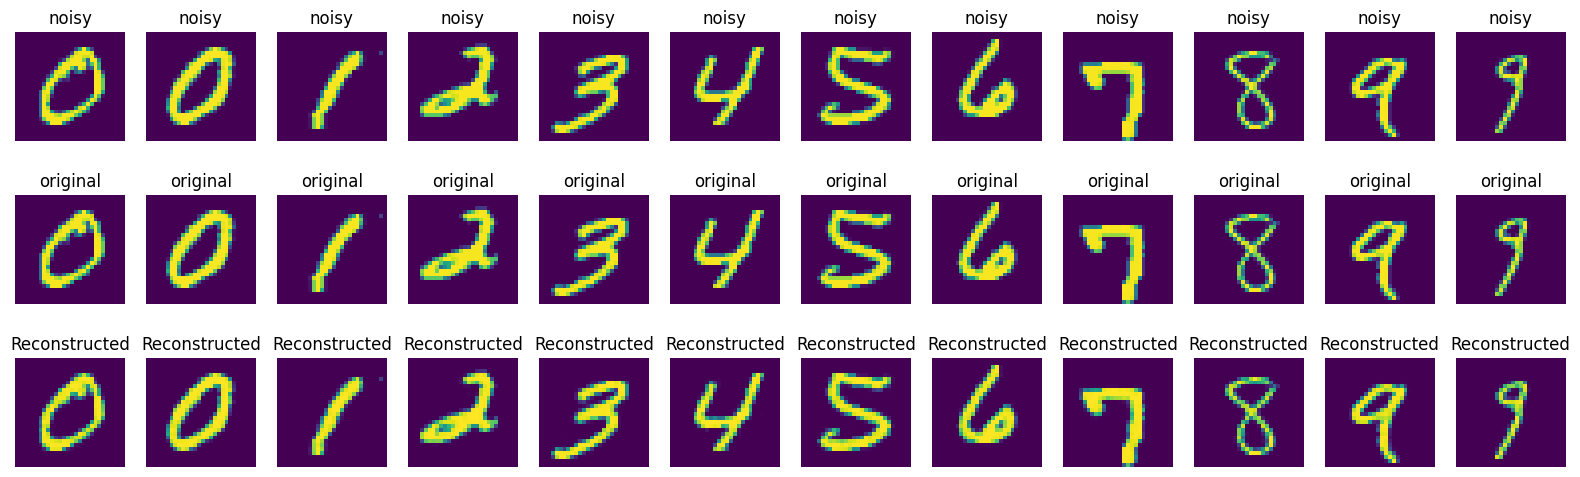

Mean difference between original and reconstructed: 0.00651159044355154


In [23]:
autoencoder.fit(selected_digits, selected_digits, epochs=20, batch_size=200, shuffle=True, verbose=0)

decoded_imgs = autoencoder.predict(selected_digits)

plot_images(selected_digits, selected_digits, decoded_imgs, n=12)

mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))

print(f"Mean difference between original and reconstructed: {mean_diff_decoded_original}")

#### Predicting noised

Epoch 1/30
5/5 [==============================] - 0s 43ms/step - loss: 0.0616
Epoch 2/30
5/5 [==============================] - 0s 41ms/step - loss: 0.0616
Epoch 3/30
5/5 [==============================] - 0s 35ms/step - loss: 0.0616
Epoch 4/30
5/5 [==============================] - 0s 35ms/step - loss: 0.0616
Epoch 5/30
5/5 [==============================] - 0s 38ms/step - loss: 0.0616
Epoch 6/30
5/5 [==============================] - 0s 42ms/step - loss: 0.0615
Epoch 7/30
5/5 [==============================] - 0s 33ms/step - loss: 0.0615
Epoch 8/30
5/5 [==============================] - 0s 33ms/step - loss: 0.0615
Epoch 9/30
5/5 [==============================] - 0s 36ms/step - loss: 0.0615
Epoch 10/30
5/5 [==============================] - 0s 37ms/step - loss: 0.0616
Epoch 11/30
5/5 [==============================] - 0s 55ms/step - loss: 0.0617
Epoch 12/30
5/5 [==============================] - 0s 34ms/step - loss: 0.0617
Epoch 13/30
5/5 [==============================] - 0s 35ms/st

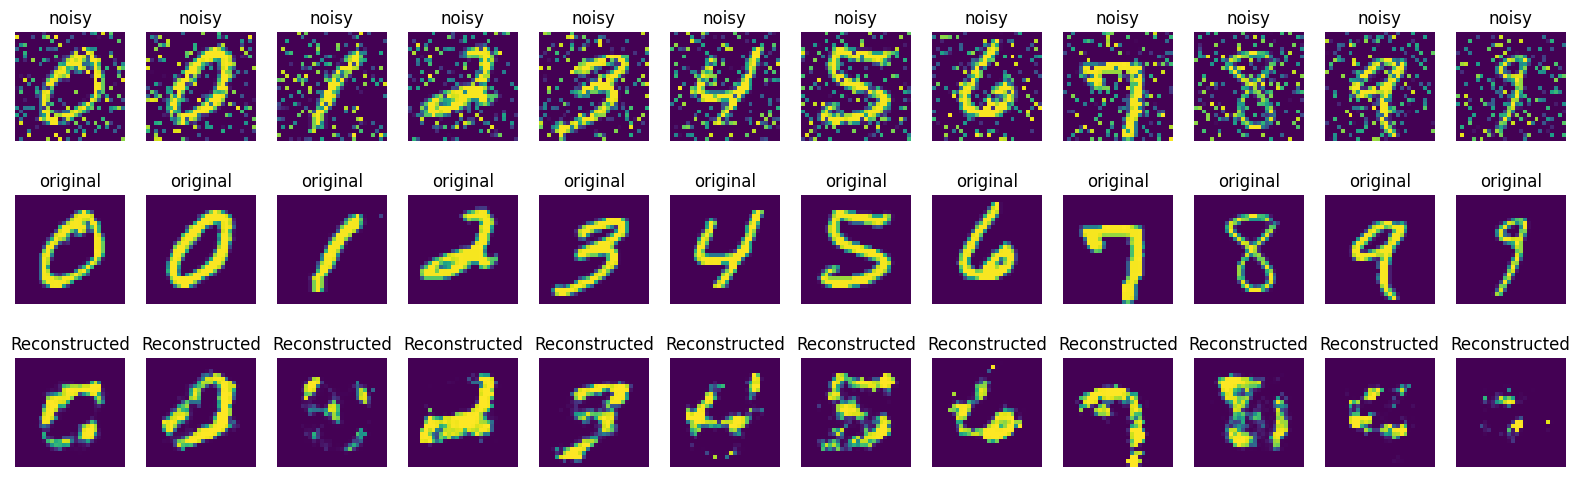

Mean difference between original and 20% noised: 0.09578946977853775
Mean difference between original and reconstructed: 0.08561224490404129


In [20]:
decoded_imgs = autoencoder.predict(rand20_digits)

plot_images(selected_digits, rand20_digits, decoded_imgs, n=12)

mean_diff_noisy_original = np.mean(np.abs(selected_digits - rand20_digits))
mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))

print(f"Mean difference between original and 20% noised: {mean_diff_noisy_original}")
print(f"Mean difference between original and reconstructed: {mean_diff_decoded_original}")

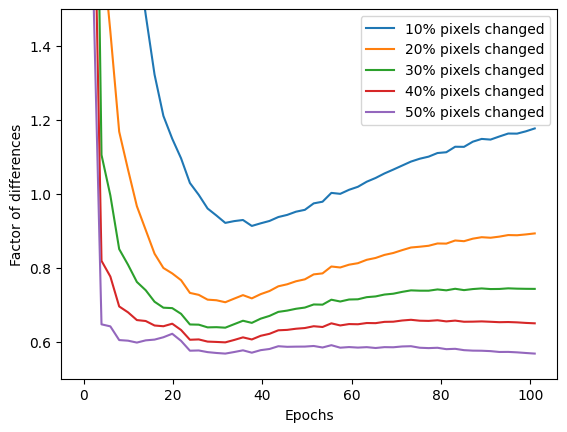

In [18]:
plt.plot(epochs, a_rand10, label='10% pixels changed')
plt.plot(epochs, a_rand20, label='20% pixels changed')
plt.plot(epochs, a_rand30, label='30% pixels changed')
plt.plot(epochs, a_rand40, label='40% pixels changed')
plt.plot(epochs, a_rand50, label='50% pixels changed')
plt.ylim(0.5,1.5)
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.legend()
plt.show()

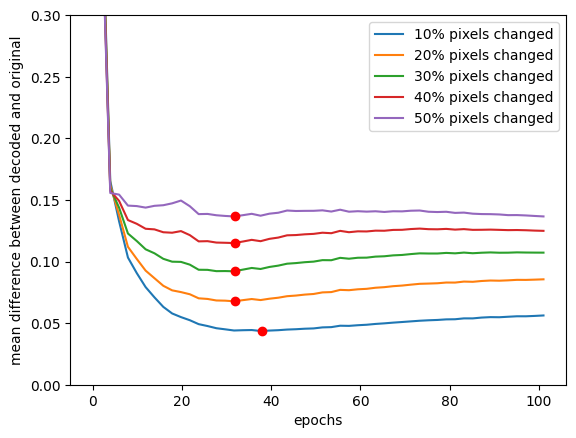

In [19]:
plt.plot(epochs, diff_rand10, label='10% pixels changed')
plt.plot(epochs, diff_rand20, label='20% pixels changed')
plt.plot(epochs, diff_rand30, label='30% pixels changed')
plt.plot(epochs, diff_rand40, label='40% pixels changed')
plt.plot(epochs, diff_rand50, label='50% pixels changed')
plt.plot(2*np.argmin(diff_rand10),np.min(diff_rand10),'ro')
plt.plot(2*np.argmin(diff_rand20),np.min(diff_rand20),'ro')
plt.plot(2*np.argmin(diff_rand30),np.min(diff_rand30),'ro')
plt.plot(2*np.argmin(diff_rand40),np.min(diff_rand40),'ro')
plt.plot(2*np.argmin(diff_rand50),np.min(diff_rand50),'ro')
plt.xlabel('epochs')
plt.ylabel('mean difference between decoded and original')
plt.ylim(0,0.3)
plt.legend()
plt.show()

## Conclusions:

The idea was basically simple: teach the autoencoder few digits without noise and observe how it will react to such digits with noise in the input. Given the small amount of training data, it is likely that the autoencoder was overfitted, but that was a bit of the point - Hopfield networks are also somehow overfitted, they don't know any properties of noise and yet they reproduce data. I wanted to get similar behavior in the autoencoder.

Generally speaking, my two autoencoders have not adapted very well that to the task at hand. It seems that my autoencoders were unable to ignore the noise, but interpreted it as an important part of the input vector, even though mostly the noise appears where the original value was 0. During the learning process, you can see the moment (around epoch 20) when the autoencoder is not "overfitted enough" and the errors in the reproduction of noisy digits reach a minimum, but still the result is far from the expected as was visible in the two samples.

The simplest solution is probably to teach the autoencoder with noised->original pairs and minimize the loss. I was hoping that the autoencoder would somehow match any noise without knowing its properties, but it looks like that just doesn't work.
